#Ejercicio 2

*Dertiano Mercedes y Natasha Itzcovich*

**Aspectos generales:**

Recordar establecer los métodos de validación para cada punto.

Para ambos ejercicios, probar las siguientes funciones de Keras con sus hiperparámetros asociados:


*   Early stopping
*   Model checkpoint
*   Scheduling learning rate

También levantar las curvas de aprendizaje en Tensorboard. 



Evaluar el compartamiento del modelo utilizando diferentes técnicas de regularización como:

*   Drop out
*   Regularización L1
*   Regularización L2
*   Batch Normalization

**CONSIGNA:**

Para este ejercicio se provee una base de datos con los costos de la atención médica de pacientes. El objetivo es realizar una estimación del costo de la atención para un paciente dado. Para esto realizar:

<ol start = "1">
  <li> Regresión lineal </li>
  <li> Regresión lineal + feature engineering </li>
  <li> Regresión utilizando MLP </li>
    <ul type="none">
      <li> En este punto, tener en cuenta los siguientes elementos: </li>
        <ul>
          <li> Ingresar con una matríz de embeddings de dimensionalidad 2 sobre la región </li>
            <ul type="circle">
              <li> Monitorear con tensorboard la evolución de los mismos </li>
            </ul>
          <li> Topología e hiperparámetros </li>
            <ul type="circle">
              <li> Cantidad de capas </li>
              <li> Cantidad de neuronas por capa </li>
              <li> Funciones de activación </li>
              <li> Optimizadores (tipos, learning rate y beta)</li>
            </ul>
          <li> Buscar formas de darle interpretabilidad a la red (o a los parámetros aprendidos) </li>
        </ul>
    </ul>
</ol>

La **métrica principal** en este punto: Mean Absolute Error (MAE)



**Pregunta adicional:**

Comparar Mean Square Error (MSE) con Mean Absolute Error (MAE). ¿En qué suposición se basa cada una?

In [7]:
#Montando el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datos

In [8]:
#Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly as py

In [9]:
#Importando dataframe
df = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/Datasets/insurance.csv', delimiter=',')

*Variables del dataset:*

**Age:** edad del titular.

**Sex:** sexo del titular (f o m).

**BMI:** ICM del titular [kg/m^2].

**Children:** cantidad de niños incluidos en el plan de cobertura.

**Smoker:** condición de fumador del titular.

**Region:** región donde reside el titular en EEUU. Opciones: noreste, sureste, noroeste, suroeste.

**Charges:** costo individual del seguro médico.

Podemos destacar que 3 variables son de tipo categóricas: sex, smoker, region. Además, ninguna de estas es de tipo ordinal.

In [18]:
#Divido al dataset en 2:
#TRAIN 80% - TEST 20%
#Mas adelante divido VALID
from sklearn.model_selection import train_test_split

test_proportion = 0.2
atributos = df.iloc[:, 0:6] #tomo las primeras 6 columnas

x_train, x_test, y_train, y_test = train_test_split(atributos,df['charges'],test_size=test_proportion,shuffle=True)

#Preparando el dataset

## HOV

Paso variables categóricas a un nuevo formato

In [19]:
#Copio subsets
train_x=x_train.copy()
valid_x=x_valid.copy()
test_x=x_test.copy()
train_y=y_train.copy()
valid_y=y_valid.copy()
test_y=y_test.copy()

In [20]:
#One Hot Encoder
train_x=pd.get_dummies(train_x, columns=['sex','smoker','region'])
valid_x=pd.get_dummies(valid_x, columns=['sex','smoker','region'])
test_x=pd.get_dummies(test_x, columns=['sex','smoker','region'])
#train_x = train_x.rename(columns={0: 'NE',1: 'NW',2: 'SE',3: 'SW'})
#valid_x = valid_x.rename(columns={0: 'NE',1: 'NW',2: 'SE',3: 'SW'})
#test_x = test_x.rename(columns={0: 'NE',1: 'NW',2: 'SE',3: 'SW'})

## Normalizando

In [21]:
train_stats = train_x.describe()
train_stats = train_stats.transpose()

In [22]:
def norm_x(x):
  return (x - train_stats['mean']) / train_stats['std'] #USO LA MEDIA Y DESVIO ESTANDAR DE TRAIN PARA NORMALIZAR TEST Y VALID
xtrain = norm_x(train_x)
xvalid = norm_x(valid_x)
xtest = norm_x(test_x)

In [23]:
def norm_y(y):
  return (y - y.mean()) / y.std() #USO LA MEDIA Y DESVIO ESTANDAR DE TRAIN PARA NORMALIZAR TEST Y VALID
ytrain = norm_y(train_y)
yvalid = norm_y(valid_y)
ytest = norm_y(test_y)

# 1 Regresión lineal



1- Load Data.

2- Define Keras Model.

3- Compile Keras Model --> We must specify the **loss function** to use to evaluate a set of weights, the **optimizer** is used to search through different weights for the network and any **optional metrics** we would like to collect and report during training.

4- Fit Keras Model --> select number of epochs and batch size

5- Evaluate Keras Model.

6- Tie It All Together.

7- Make Predictions

In [64]:
#Cantidad de parámetros de entrada:
n = xtrain.shape[1]
#model.add(Dense(12, input_dim=n, activation='relu'))
from keras.models import Sequential
from keras.layers import Dense 
from keras.optimizers import SGD, Adam, schedules
import keras

## Prueba 1

In [27]:
#Definición + compilación modelo 
def build_model():
  model = Sequential([
    Dense(11, input_dim=n),
    Dense(11),
    Dense(1)
  ])
  optimizer=Adam(learning_rate=0.001) ############# OPTIMIZADOR y LEARNING RATE
  model.compile(loss='mse',optimizer=optimizer, metrics=['mae', 'mse'])
  return model

model1 = build_model()

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_10 (Dense)             (None, 11)                132       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 12        
Total params: 276
Trainable params: 276
Non-trainable params: 0
_________________________________________________________________


In [28]:
#Entrenamiento
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000 ############# CANTIDAD EPOCHS

print('Comenzando entrenamiento del modelo')
history1 = model1.fit(xtrain, ytrain, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

#Viendo los últimos resultados
hist = pd.DataFrame(history1.history)
hist['epoch'] = history1.epoch
print('')
print('loss=MSE train')
print('val_loss=MSE valid')
hist.tail()

Comenzando entrenamiento del modelo

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.237591,0.330395,0.237591,0.280962,0.365436,0.280962,995
996,0.237151,0.330871,0.237151,0.280554,0.368746,0.280554,996
997,0.237173,0.331552,0.237173,0.281587,0.366274,0.281587,997
998,0.237945,0.331787,0.237945,0.280046,0.369430,0.280046,998
999,0.238038,0.331048,0.238038,0.279645,0.367080,0.279645,999


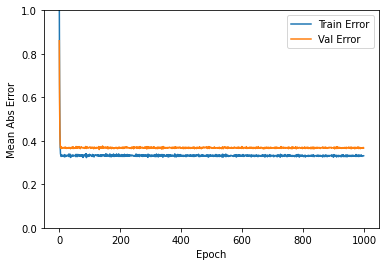

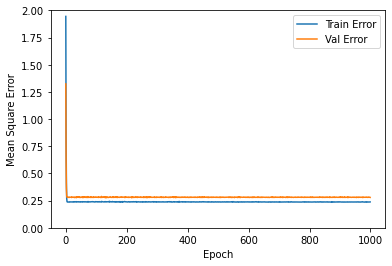

In [32]:
#Curvas de aprendizaje
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  #PLOTTING MAE
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()

  #PLOTTING MSE
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()
  plt.show()

plot_history(history1)

El gráfico presenta un comportamiento practicamente constante después de las 100 epochs. Usando la función de **early stopping** se busca parar el entrenamiento cuando ya no haya cambios significativo en el entrenamiento del modelo.


### Early stopping


..........................

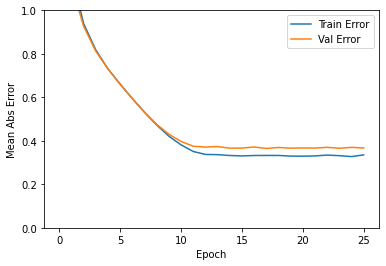

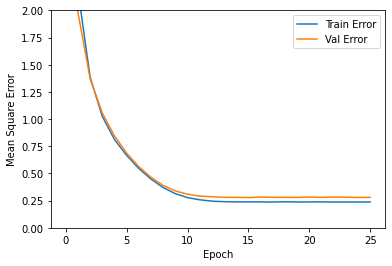

In [40]:
model1ES = build_model()

early_stop1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history1ES = model1ES.fit(xtrain, ytrain, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop1, PrintDot()])

plot_history(history1ES)

In [41]:
#Evaluando en subset test sin early stopping
loss, mae, mse = model1.evaluate(xtest, ytest, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

9/9 - 0s - loss: 0.2722 - mae: 0.3410 - mse: 0.2722
Testing set Mean Abs Error:  0.34


In [42]:
#Evaluando en subset test con early stopping
loss, mae, mse = model1ES.evaluate(xtest, ytest, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

9/9 - 0s - loss: 0.2710 - mae: 0.3397 - mse: 0.2710
Testing set Mean Abs Error:  0.34


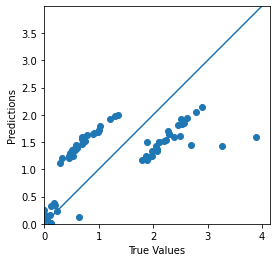

In [44]:
test_predictions1 = model1ES.predict(xtest).flatten()

plt.scatter(ytest, test_predictions1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### Model checkpoint

In [65]:
#checkpoint_filepath = '/content/drive/MyDrive/Redes Neuronales'

xtrain_array = np.asarray(xtrain)
ytrain_array = np.asarray(ytrain)

model1MC = build_model()

print('Comenzando entrenamiento del modelo')
history1MC = model1MC.fit(xtrain_array, ytrain_array, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

checkpoint_filepath ='/tmp/checkpoint'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen so far.
model1MC.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model1MC.load_weights(checkpoint_filepath)

Comenzando entrenamiento del modelo


KeyboardInterrupt: ignored

In [48]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=2),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]
model1.fit(xtrain, epochs=10, callbacks=my_callbacks)

Epoch 1/10


ValueError: ignored

In [ ]:
#2 https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/
#INTRO A KERAS: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
import random
index=np.arange(10000)
np.random.shuffle(index)
x1_train=x1[index[:8000]]
y_train=y[index[:8000]]
x1_test=x1[index[8000:]]
y_test=y[index[8000:]]

# Train the model, iterating on the data in batches of 256 samples
history=model.fit(x1_train, y_train, validation_data=[x1_test,y_test],epochs=100,verbose=1, batch_size=64,shuffle = True)

### Learning rate schedule


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

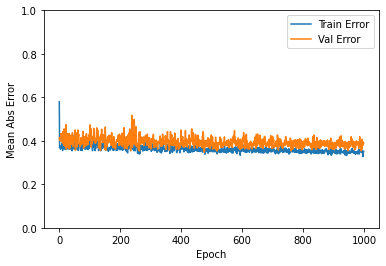

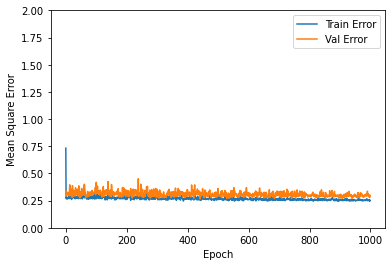

In [77]:
initial_learning_rate = 0.1
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model1LRS = Sequential([Dense(1, input_dim=n)])
model1LRS.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae', 'mse'])

history1LRS = model1LRS.fit(xtrain, ytrain, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

plot_history(history1LRS)

In [76]:
#Evaluando en subset test sin LRS (lr=0.001)
loss, mae, mse = model1.evaluate(xtest, ytest, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

9/9 - 0s - loss: 0.2722 - mae: 0.3410 - mse: 0.2722
Testing set Mean Abs Error:  0.34


In [78]:
#Evaluando en subset test con LRS
loss, mae, mse = model1LRS.evaluate(xtest, ytest, verbose=2)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

9/9 - 0s - loss: 0.2779 - mae: 0.3444 - mse: 0.2779
Testing set Mean Abs Error:  0.34


# 2 Regresión lineal + feature engineering

In [58]:
modelsFE.intercept_

-1.5017299290401983e-15

In [59]:
modelsFE.coef_

array([ 3.15085175e-01,  1.67539903e-01,  5.03704966e-02,  6.16229130e-06,
       -6.16229130e-06, -3.95892064e-01,  3.95892064e-01,  1.37912110e-02,
        7.63173957e-03, -1.15524096e-02, -9.49587717e-03])

In [81]:
poly = PolynomialFeatures(2,include_bias=False)
train_x_p = poly.fit_transform(xtrain)
train_x_p = pd.DataFrame(train_x_p)

#valid_x_p = poly.fit_transform(valid_x)
#valid_x_p = pd.DataFrame(valid_x_p)

In [82]:
modelFE=LinearRegression()
modelFE.fit(train_x_p, ytrain)
modelFE.score(xtest, ytest)

ValueError: ignored

# 3 Regresión usando MLP